In [20]:
import pandas as pd
import numpy as np
from collections import defaultdict
import datetime
from apyori import apriori



# set names of pandas dataframe
names=['Host', 'Identd', 'Authuser', 'Date and time', 'Timezone', 'Request',
       'Status code', 'Bytes Sent', 'Referrer', 'Agent']
# read the dataframe
df = pd.read_csv('server_logs_raw.txt', sep=' ', names=names, header=None)

def extract_method_and_protocol(row):
    # function to extract HTTP request method and protocol from a request string
    request_splits = row['Request'].split()  # split request string by space
    row['Method'] = request_splits[0]
    row['Protocol'] = request_splits[-1]
    row['Request'] = ' '.join(request_splits[1:-1])  # stitch remaining request string back
    return row

df = df.apply(extract_method_and_protocol, axis=1)

# correct the incorrect dataframe types
df['Status code'] = df['Status code'].astype(int)  # set status code to int
df['Datetime'] = pd.to_datetime(df['Date and time'], format='[%d/%b/%Y:%H:%M:%S')  # set date time to pandas datatime obj
df = df.drop(['Date and time'], axis=1)

# create a mask to filter all images
mask = (df['Request'].str.endswith('.gif') | df['Request'].str.endswith('.jpg') | df['Request'].str.endswith('.jpeg') | df['Request'].str.endswith('.png') | df['Request'].str.endswith('.svg') | df['Request'].str.endswith('.ico') | df['Request'].str.endswith('.css')  | df['Request'].str.endswith('.ttf') | df['Request'].str.endswith('.js') )

print("# Rows before:", len(df))

# invert the mask, only keep records without images, font files, css files and js files in the request column
df2 = df[~mask]

mask2 =  (df2['Agent'].str.find('http') != -1)
df2 = df2[~mask2]

print("After images removal", len(df2))

# second mask, remove all unsuccessful requests (code != 200)
df2 = df2[df2['Status code'] == 200]
print("After unsuccessful requests removal", len(df2))

# first, make a copy of df2 just in case
df3 = df2.copy()

# sort the rows based on datetime, descending
df3.sort_values(by='Datetime', inplace=True)

# initiate session ID and user ID to 0
session_id = 0
user_id = 0

# create a dictionaries to hold last access information
last_access = defaultdict(lambda:datetime.datetime.utcfromtimestamp(0))

# dictionary to find previous session, user ID and steps assigned to a specific date/ip/browser key
session_dict = defaultdict(lambda:1)
user_id_dict = defaultdict(lambda:1)
session_steps = defaultdict(lambda:1)

# function to be applied row wise
# for each row, produce session, user ID and path traversal
def get_log_user_info(row):
    # access global variables shared between all rows
    global session_id, user_id, session_dict, user_id_dict, session_steps, last_access
    
    session_key = str(row['Datetime'].date()) + '_' + row['Host']  # date + IP key for finding session
    user_key = str(row['Datetime'].date()) + '_' + row['Host'] + '_' + row['Agent']  # date + IP + browser key for finding user
    time_diff_session = row['Datetime'] - last_access[session_key]  # session time diff
    time_diff_user = row['Datetime'] - last_access[user_key]  # user time diff
    
    # if the time diff from previous session is > 30 mins, assign new session ID
    if time_diff_session.total_seconds() > 1800:
        session_id += 1
        session_dict[session_key] = session_id
    
    # if the time diff from previous session is > 60 mins, assign new user ID
    if time_diff_user.total_seconds() > 3600:
        user_id += 1
        user_id_dict[user_key] = user_id
        
    # update last access for session and user
    last_access[session_key] = row['Datetime']
    last_access[user_key] = row['Datetime']
    
    # assign extracted info from the row
    row['Session'] = session_dict[session_key]
    row['Step'] = session_steps[row['Session']]
    row['User_ID'] = user_id_dict[user_key]
    session_steps[row['Session']] += 1
    return row
    
# apply function above to get a new dataframe with added information
df3 = df3.apply(get_log_user_info, axis=1)
df3.sort_values(by='User_ID', inplace=True)
df3.head(10)

# Rows before: 9999
After images removal 2396
After unsuccessful requests removal 2135


,Host,Identd,Authuser,Timezone,Request,Status code,Bytes Sent,Referrer,Agent,Method,Protocol,Datetime,Session,Step,User_ID
68,81.220.24.207,-,-,+0000],/blog/geekery/ssl-latency.html,200,17147,http://www.google.fr/url?sa=t&rct=j&q=&esrc=s&...,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_1)...,GET,HTTP/1.1,2015-05-17 10:05:13,1,2,1
24,93.114.45.13,-,-,+0000],/articles/dynamic-dns-with-dhcp/,200,18848,http://www.google.ro/url?sa=t&rct=j&q=&esrc=s&...,Mozilla/5.0 (X11; Linux x86_64; rv:25.0) Gecko...,GET,HTTP/1.1,2015-05-17 10:05:14,2,1,2
52,67.214.178.190,-,-,+0000],/blog/geekery/installing-windows-8-consumer-pr...,200,8948,http://www.semicomplete.com/,Mozilla/5.0 (Macintosh; Intel Mac OS X 10.7; r...,GET,HTTP/1.0,2015-05-17 10:05:18,3,1,3
51,67.214.178.190,-,-,+0000],/,200,37932,http://www.semicomplete.com/,Mozilla/5.0 (Macintosh; Intel Mac OS X 10.7; r...,GET,HTTP/1.0,2015-05-17 10:05:48,3,2,3
56,91.177.205.119,-,-,+0000],/blog/geekery/xvfb-firefox.html,200,10975,http://en.wikipedia.org/wiki/Xvfb,Mozilla/5.0 (compatible; MSIE 10.0; Windows NT...,GET,HTTP/1.1,2015-05-17 10:05:22,4,1,4
33,110.136.166.128,-,-,+0000],/projects/xdotool/,200,12292,http://www.google.com/url?sa=t&rct=j&q=&esrc=s...,Mozilla/5.0 (Windows NT 6.2; WOW64; rv:28.0) G...,GET,HTTP/1.1,2015-05-17 10:05:35,5,1,5
44,200.49.190.100,-,-,+0000],/blog/tags/web,200,44019,-,QS304 Profile/MIDP-2.0 Configuration/CLDC-1.1,GET,HTTP/1.1,2015-05-17 10:05:38,6,1,6
65,87.169.99.232,-,-,+0000],/presentations/puppet-at-loggly/puppet-at-logg...,200,24747,https://www.google.de/,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_1)...,GET,HTTP/1.1,2015-05-17 10:05:59,7,1,7
118,208.115.111.72,-,-,+0000],/files/xdotool/docs/man/?C=M;O=D,200,959,-,Mozilla/5.0 (compatible; Ezooms/1.0; help@moz....,GET,HTTP/1.1,2015-05-17 11:05:19,8,11,8
114,208.115.111.72,-,-,+0000],/files/blogposts/20070901/?C=D;O=A,200,980,-,Mozilla/5.0 (compatible; Ezooms/1.0; help@moz....,GET,HTTP/1.1,2015-05-17 11:05:23,8,12,8


No. of Unique Ip Addresses : 1081
No. of Unique Session : 1387
No. of Unique User : 1343
No. of Unique Referrer : 438
No. of Unique Method : GET     2116
HEAD      17
POST       2
Name: Method, dtype: int64
No. of Unique Agent : Mozilla/5.0 (Macintosh; Intel Mac OS X 10.7; rv:22.0) Gecko/20100101 Firefox/22.0                                                               160
Mozilla/5.0 (compatible; Ezooms/1.0; help@moz.com)                                                                                              152
Mozilla/5.0 (Macintosh; Intel Mac OS X 10.7; rv:21.0) Gecko/20100101 Firefox/21.0                                                               131
Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/32.0.1700.107 Safari/537.36                                    98
Mozilla/5.0 (compatible; MSIE 9.0; Windows NT 6.1; WOW64; Trident/5.0; chromeframe/19.0.1084.52)                                                 84
-                              

Text(0.5, 1.0, 'Most Popular Requests by the Users')

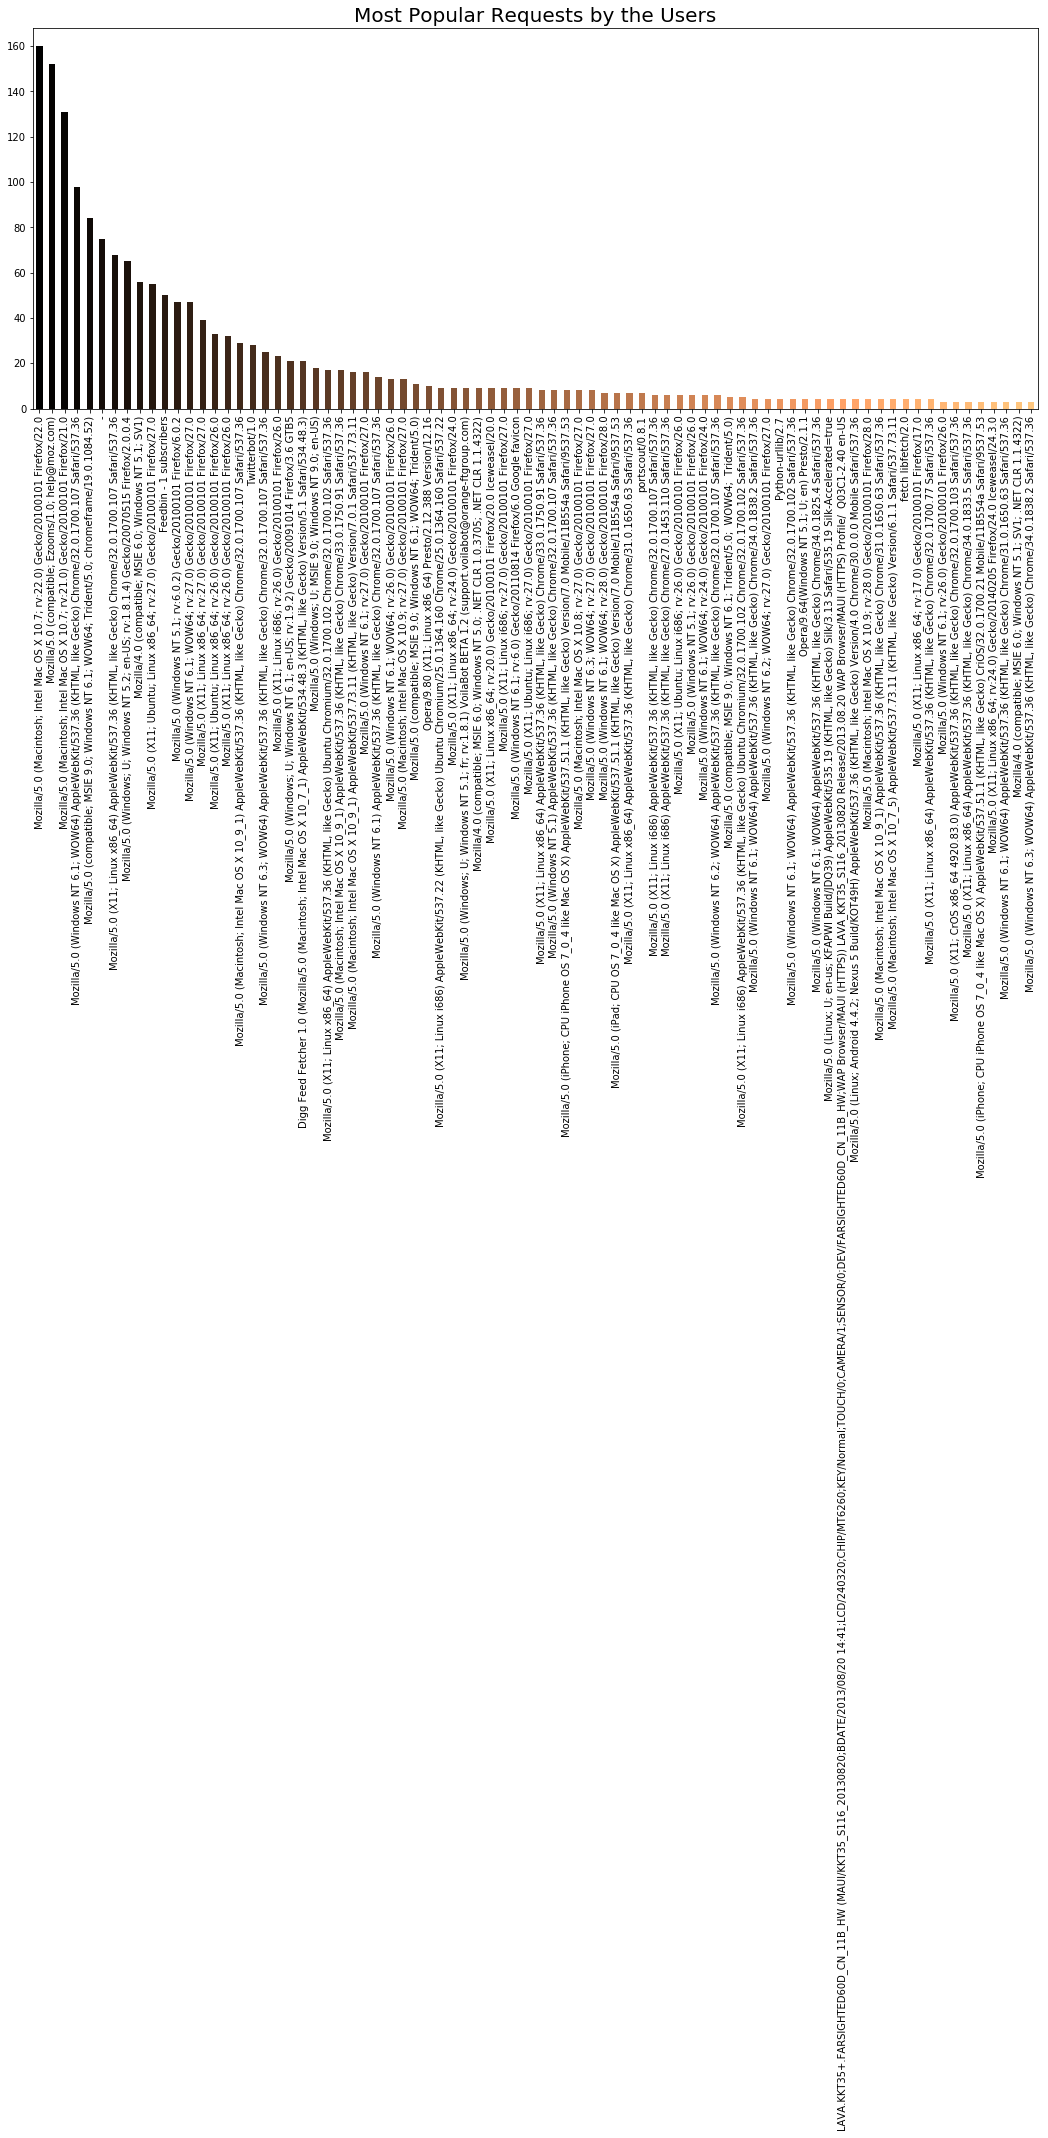

In [22]:
print("No. of Unique Ip Addresses :", df3['Host'].nunique())
print("No. of Unique Session :", df3['Session'].nunique())
print("No. of Unique User :", df3['User_ID'].nunique())
print("No. of Unique Referrer :", df3['Referrer'].nunique())
print("No. of Unique Method :", df3['Method'].value_counts())
print("No. of Unique Agent :", df3['Agent'].value_counts())



# for visualizations
import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams['figure.figsize'] = (18, 7)

color = plt.cm.copper(np.linspace(0, 1, 80))
df3['Agent'].value_counts().head(80).plot.bar(color = color)
plt.title('Most Popular Requests by the Users', fontsize = 20)


In [25]:
transactions = df3.groupby(['User_ID'])['Request'].apply(list)


# type cast the transactions from pandas into normal list format and run apriori
transaction_list = list(transactions)

for transaction in transaction_list:
    if len(transaction) == 1:
        transaction_list.remove(transaction)
results = list(apriori(transaction_list, min_support=0.02))


def convert_apriori_results_to_pandas_df(results):
    rules = []
    
    for rule_set in results:
        for rule in rule_set.ordered_statistics:
            # items_base = left side of rules, items_add = right side
            # support, confidence and lift for respective rules
            rules.append([','.join(rule.items_base), ','.join(rule.items_add),
                         rule_set.support, rule.confidence, rule.lift]) 
    
    # typecast it to pandas df
    return pd.DataFrame(rules, columns=['Left_side', 'Right_side', 'Support', 'Confidence', 'Lift']) 

result_df = convert_apriori_results_to_pandas_df(results)


result_df = result_df.sort_values(by='Lift', ascending=False)
print(result_df.head(8))
np.savetxt(r'np.txt', result_df.values, fmt='%s')

                                            Left_side  \
22           /presentations/logstash-puppetconf-2012/   
23  /presentations/puppet-at-loggly/puppet-at-logg...   
19                                                  /   
20  /blog/geekery/installing-windows-8-consumer-pr...   
17                            /articles/ssh-security/   
16                                                  /   
26                    /projects/xdotool/xdotool.xhtml   
25                                 /projects/xdotool/   

                                           Right_side   Support  Confidence  \
22  /presentations/puppet-at-loggly/puppet-at-logg...  0.028796    0.666667   
23           /presentations/logstash-puppetconf-2012/  0.028796    0.733333   
19  /blog/geekery/installing-windows-8-consumer-pr...  0.039267    0.329670   
20                                                  /  0.039267    0.967742   
17                                                  /  0.027487    0.617647   
16          

In [17]:
np.savetxt(r'np.txt', df3.values, fmt='%s')